### Инструкция по выполнению проекта:

Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

#### Описание данных
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

# Шаг 1. Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
try:
    visits, orders, costs = (
        pd.read_csv('/datasets/visits_info_short.csv'),  # журнал сессий
        pd.read_csv('/datasets/orders_info_short.csv'),  # покупки
        pd.read_csv('/datasets/costs_info_short.csv'),  # траты на рекламу
    )
except FileNotFoundError:
    print('Указан неверный путь к файлу')

In [3]:
visits = visits.rename(columns={'User Id':'user_id', 'Region':'region', 'Device':'device', 'Channel':'channel',
                       'Session Start':'session_start', 'Session End':'session_end'})

orders = orders.rename(columns={'User Id':'user_id', 'Event Dt':'event_dt', 'Revenue':'revenue'})

costs = costs.rename(columns={'Channel':'channel'})

In [4]:
# Преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [5]:
visits.info()
print()
orders.info()
print()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942

Данные о времени преобразованы к нужным типам; типы данных остальных колонок - верные.

In [6]:
print('Количество полных дубликатов в таблице visits: ', visits.duplicated().sum())
print('Количество полных дубликатов в таблице orders: ', orders.duplicated().sum())
print('Количество полных дубликатов в таблице costs: ', costs.duplicated().sum())

Количество полных дубликатов в таблице visits:  0
Количество полных дубликатов в таблице orders:  0
Количество полных дубликатов в таблице costs:  0


Полных дубликатов в данных не обнаружено.

Внимательнее посмотрим на качество данных - проверим на наличие пропусков, ошибочных значений, а также проверим общие статистики:

In [7]:
print(visits.isna().sum())
print()
print(visits.value_counts())
print()
print(visits.describe())

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

user_id       region         device   channel       session_start        session_end        
599326        United States  Android  FaceBoom      2019-05-08 06:00:42  2019-05-08 06:52:28    1
666436527290  United States  iPhone   TipTop        2019-10-23 21:07:52  2019-10-23 21:08:10    1
666435389723  France         iPhone   LeapBob       2019-07-19 15:48:19  2019-07-19 15:51:50    1
                                                    2019-07-15 20:29:18  2019-07-15 21:54:45    1
666433868763  United States  iPhone   MediaTornado  2019-10-05 00:09:54  2019-10-05 00:21:30    1
                                                                                               ..
332723282266  United States  PC       TipTop        2019-10-14 19:12:17  2019-10-14 20:21:35    1
                                                    2019-10-13 16:48:25  2019-10-13 17:46:12 

In [8]:
print(orders.isna().sum())
print()
print(orders.value_counts())
print()
print(orders.describe())

user_id     0
event_dt    0
revenue     0
dtype: int64

user_id       event_dt             revenue
599326        2019-05-07 20:59:09  4.99       1
660787742648  2019-10-16 22:55:01  4.99       1
660764823805  2019-07-17 09:03:36  4.99       1
              2019-08-05 21:01:38  4.99       1
              2019-08-10 23:57:13  4.99       1
                                             ..
338276441244  2019-10-16 13:08:54  4.99       1
338343388023  2019-05-17 12:39:43  4.99       1
              2019-05-19 17:44:07  4.99       1
              2019-05-26 15:01:30  4.99       1
999895427370  2019-09-19 23:33:23  4.99       1
Length: 40212, dtype: int64

            user_id       revenue
count  4.021200e+04  40212.000000
mean   4.990295e+11      5.370608
std    2.860937e+11      3.454208
min    5.993260e+05      4.990000
25%    2.511324e+11      4.990000
50%    4.982840e+11      4.990000
75%    7.433327e+11      4.990000
max    9.998954e+11     49.990000


In [9]:
print(costs.isna().sum())
print()
print(costs.value_counts())
print()
print(costs.describe())

dt         0
channel    0
costs      0
dtype: int64

dt          channel             costs  
2019-05-01  AdNonSense          40.950     1
2019-09-01  WahooNetBanner      36.000     1
2019-08-29  WahooNetBanner      35.400     1
            TipTop              318.000    1
            RocketSuperAds      5.850      1
                                          ..
2019-06-29  TipTop              322.400    1
            RocketSuperAds      6.825      1
            OppleCreativeMedia  18.000     1
            MediaTornado        5.520      1
2019-10-27  lambdaMediaAds      12.000     1
Length: 1800, dtype: int64

             costs
count  1800.000000
mean     58.609611
std     107.740223
min       0.800000
25%       6.495000
50%      12.285000
75%      33.600000
max     630.000000


# Шаг 2. Написание функций для расчета и анализа LTV, ROI, удержания и конверсии

In [10]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [11]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [12]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [13]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

# Шаг 3. Исследовательский анализ данных

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [14]:
#Получим профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [15]:
display('Минимальная дата привлечения пользователей:', profiles['dt'].min())
display('Максимальная дата привлечения пользователей:', profiles['dt'].max())

'Минимальная дата привлечения пользователей:'

datetime.date(2019, 5, 1)

'Максимальная дата привлечения пользователей:'

datetime.date(2019, 10, 27)

Минимальная дата привлечения пользователей - **01.05.2019**, максимальная - **27.10.2019**

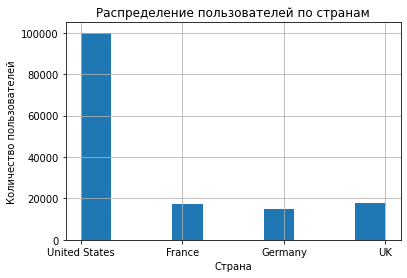

region         payer
France         False    16787
               True       663
Germany        False    14365
               True       616
UK             False    16875
               True       700
United States  False    93100
               True      6902
Name: user_id, dtype: int64

In [16]:
profiles['region'].hist(bins=10) #рассмотрим соотношение количества пользователей из разных стран
plt.title('Распределение пользователей по странам')
plt.xlabel('Страна')
plt.ylabel('Количество пользователей')
plt.show()
profiles_grouped = profiles.groupby(['region', 'payer'])
profiles_grouped['user_id'].nunique()

Судя по графику количества пользователей, сильно преобладают пользователи из США. Количество посещений из США - около **100000**. Количество посещений из Франции, Германии или Великобритании не превышает 20000. Платящих пользователей также больше всего в США - **6902**.

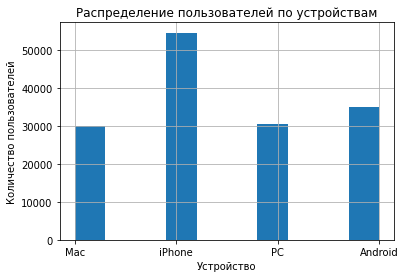

device   payer
Android  False    32982
         True      2050
Mac      False    28130
         True      1912
PC       False    28918
         True      1537
iPhone   False    51097
         True      3382
Name: user_id, dtype: int64

In [17]:
profiles['device'].hist(bins=10) #рассмотрим соотношение устройств пользователей
plt.title('Распределение пользователей по устройствам')
plt.xlabel('Устройство')
plt.ylabel('Количество пользователей')
plt.show()
profiles_grouped = profiles.groupby(['device', 'payer'])
profiles_grouped['user_id'].nunique()

Наиболее популярное устройство среди пользователей - **iPhone** (более 50000). Чаще всего платящие пользователи заходят именно с устройства iPhone: их количество составляет **3382**.

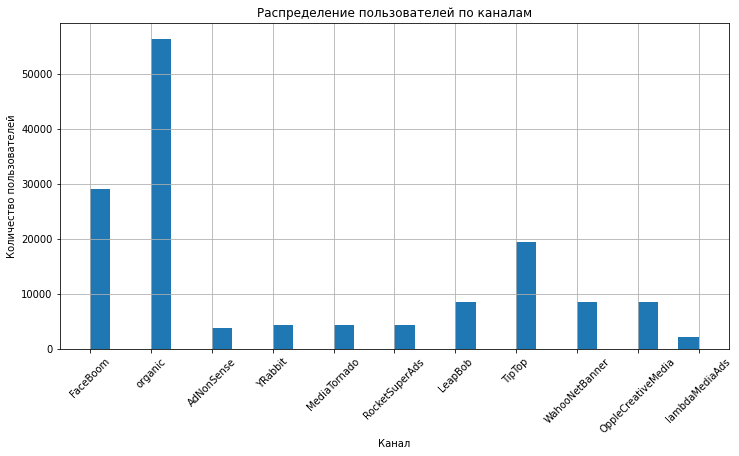

channel             payer
AdNonSense          False     3440
                    True       440
FaceBoom            False    25587
                    True      3557
LeapBob             False     8291
                    True       262
MediaTornado        False     4208
                    True       156
OppleCreativeMedia  False     8372
                    True       233
RocketSuperAds      False     4096
                    True       352
TipTop              False    17683
                    True      1878
WahooNetBanner      False     8100
                    True       453
YRabbit             False     4147
                    True       165
lambdaMediaAds      False     1924
                    True       225
organic             False    55279
                    True      1160
Name: user_id, dtype: int64

In [18]:
profiles['channel'].hist(bins=30, xrot=45, figsize=(12,6)) #рассмотрим соотношение каналов привлечения пользователей
plt.title('Распределение пользователей по каналам')
plt.xlabel('Канал')
plt.ylabel('Количество пользователей')
plt.show()
profiles_grouped = profiles.groupby(['channel', 'payer'])
profiles_grouped['user_id'].nunique()

Число пользователей, привлеченных без рекламы, значительно превышает число пользователей, привлеченных по рекламным каналам. Если не рассматривать органических пользователей, то наиболее многочисленными каналами являются **FaceBoom** и **TipTop**. Платящих пользователей больше всего приносят каналы FaceBoom (**3557**) и TipTop (**1878**). Также среди органических пользователей достаточное количество платящих - **1160**, что превышает число платящих пользователей с остальных каналов.

Дополнительно создадим таблицы с профайлами:

In [19]:
region_profiles = (profiles
         .pivot_table(index='region', values='payer', aggfunc=['count', 'sum', 'mean' ])
         .reset_index()
         .rename(columns={'count':'all_users', 'sum':'paying_users', 'mean':'ratio'})
         .droplevel(1, axis=1)
         .sort_values(by='ratio', ascending=False)
         .style.format({'ratio':'{:.2%}'})
)
region_profiles

,region,all_users,paying_users,ratio
3,United States,100002,6902,6.90%
1,Germany,14981,616,4.11%
2,UK,17575,700,3.98%
0,France,17450,663,3.80%


In [20]:
device_profiles = (profiles
         .pivot_table(index='device', values='payer', aggfunc=['count', 'sum', 'mean' ])
         .reset_index()
         .rename(columns={'count':'all_users', 'sum':'paying_users', 'mean':'ratio'})
         .droplevel(1, axis=1)
         .sort_values(by='ratio', ascending=False)
         .style.format({'ratio':'{:.2%}'})
)
device_profiles

,device,all_users,paying_users,ratio
1,Mac,30042,1912,6.36%
3,iPhone,54479,3382,6.21%
0,Android,35032,2050,5.85%
2,PC,30455,1537,5.05%


In [21]:
channel_profiles = (profiles
         .pivot_table(index='channel', values='payer', aggfunc=['count', 'sum', 'mean' ])
         .reset_index()
         .rename(columns={'count':'all_users', 'sum':'paying_users', 'mean':'ratio'})
         .droplevel(1, axis=1)
         .sort_values(by='ratio', ascending=False)
         .style.format({'ratio':'{:.2%}'})
)
channel_profiles

,channel,all_users,paying_users,ratio
1,FaceBoom,29144,3557,12.20%
0,AdNonSense,3880,440,11.34%
9,lambdaMediaAds,2149,225,10.47%
6,TipTop,19561,1878,9.60%
5,RocketSuperAds,4448,352,7.91%
7,WahooNetBanner,8553,453,5.30%
8,YRabbit,4312,165,3.83%
3,MediaTornado,4364,156,3.57%
2,LeapBob,8553,262,3.06%
4,OppleCreativeMedia,8605,233,2.71%


# Шаг 4. Маркетинг

Ответим на вопросы:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [22]:
summ_cost = costs['costs'].sum()
print('Всего потрачено денег: ', summ_cost.round(2))

Всего потрачено денег:  105497.3


In [23]:
# Выясним, сколько потрачено денег на каждый источник

costs_by_channel = costs.groupby('channel')['costs'].sum().reset_index()
costs_by_channel['%'] = costs_by_channel['costs'] / summ_cost * 100
costs_by_channel.sort_values('%', ascending = False)

,channel,costs,%
6,TipTop,54751.30,51.898295
1,FaceBoom,32445.60,30.754910
7,WahooNetBanner,5151.00,4.882589
0,AdNonSense,3911.25,3.707441
4,OppleCreativeMedia,2151.25,2.039152
5,RocketSuperAds,1833.00,1.737485
2,LeapBob,1797.60,1.703930
9,lambdaMediaAds,1557.60,1.476436
3,MediaTornado,954.48,0.904744
8,YRabbit,944.22,0.895018


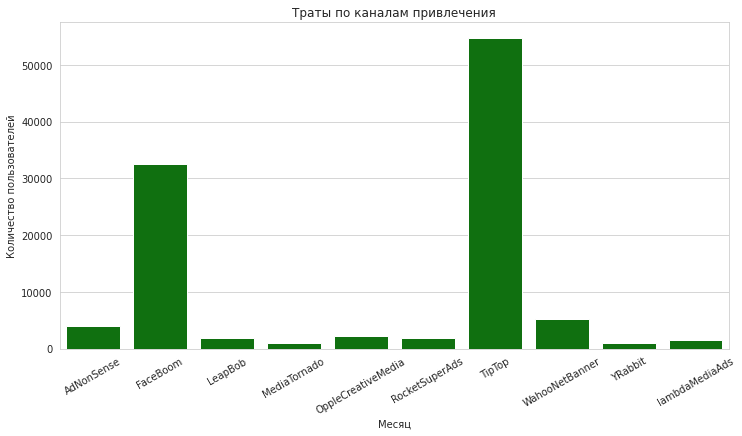

In [24]:
plt.figure(figsize=(12,6))
sns.set_style('whitegrid')
graf = sns.barplot(x='channel', y='costs', data=costs_by_channel, color='green')
graf.set_title('Траты по каналам привлечения')
graf.set_xticklabels(graf.get_xticklabels(),rotation = 30)
graf.set_xlabel('Месяц')
graf.set_ylabel('Количество пользователей')
plt.show()

Больше половины денег потрачено на канал TipTop, почти 52% от общей суммы. 31% потрачено на канал FaceBoom.

In [25]:
# Сколько денег потратили по месяцам

costs['costs_month'] = costs['dt'].astype('datetime64[M]').dt.date
costs_by_month = costs.groupby('costs_month')['costs'].sum().reset_index()
costs_by_month['%'] = costs_by_month['costs'] / summ_cost * 100
costs_by_month.sort_values('costs', ascending = False)

,costs_month,costs,%
4,2019-09-01,22441.340,21.271957
5,2019-10-01,20882.415,19.794265
3,2019-08-01,20657.870,19.581421
2,2019-07-01,16447.060,15.590029
1,2019-06-01,15090.045,14.303726
0,2019-05-01,9978.570,9.458602


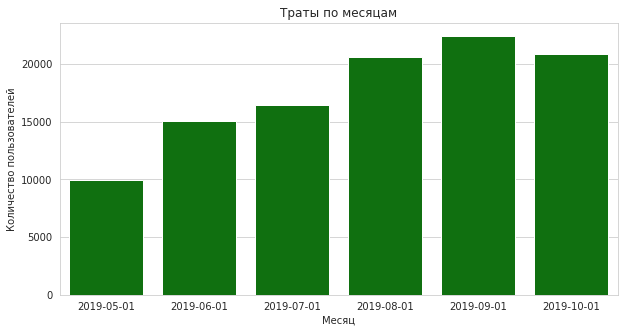

In [26]:
plt.figure(figsize=(10,5))
graf = sns.barplot(x='costs_month', y='costs', data=costs_by_month, color='green')
graf.set_title('Траты по месяцам')
graf.set_xlabel('Месяц')
graf.set_ylabel('Количество пользователей')
plt.show()

Больше всего денег потратили в **сентябре** 2019 (21%), меньше всего - в **мае** 2019 (9,5%). Также много было потрачено в октябре и августе 2019.

In [27]:
# Выясним, сколько стоило привлечение одного покупателя из каждого источника

costs_by_channel = costs.groupby('channel').agg({'costs':'sum'})
costs_by_channel = costs_by_channel.reset_index()
costs_by_channel

,channel,costs
0,AdNonSense,3911.25
1,FaceBoom,32445.60
2,LeapBob,1797.60
3,MediaTornado,954.48
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
6,TipTop,54751.30
7,WahooNetBanner,5151.00
8,YRabbit,944.22
9,lambdaMediaAds,1557.60


Проанализируем динамику маркетинговых затрат по времени с помощью линейных графиков:

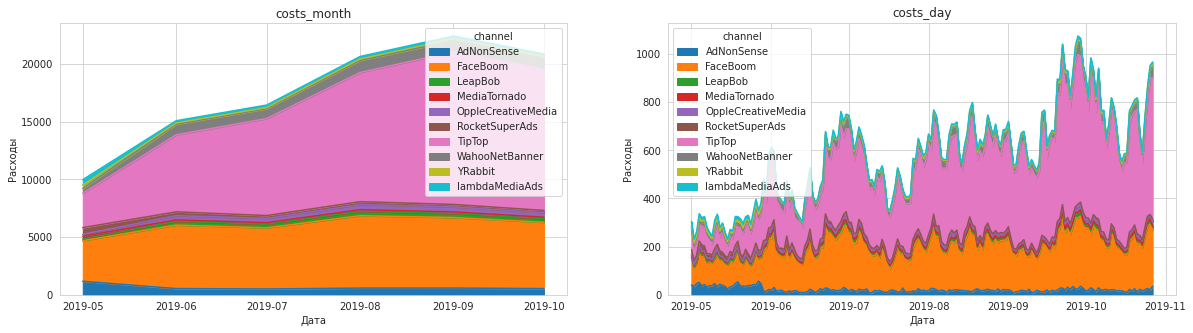

In [28]:
costs['costs_day'] = costs['dt'].astype('datetime64[D]').dt.date

cols = ['costs_month', 'costs_day']

plt.subplots(figsize = (20,5))
for i, col in enumerate(cols):
        costs.pivot_table(index = col, columns = 'channel', values = 'costs', aggfunc = 'sum').plot.area(ax = plt.subplot(1, 2, i+1))
        plt.title(col)
        plt.xlabel('Дата')
        plt.ylabel('Расходы')
        
plt.show()        

In [29]:
customers_by_channel = (orders.merge(visits, on='user_id', how='inner')).groupby('channel')\
                        .agg({'user_id':'nunique'}).rename(columns={'user_id':'customers'})
# Удалим строку с органическими пользователями
customers_by_channel = customers_by_channel.drop(axis=0, index='organic').reset_index()
customers_by_channel

,channel,customers
0,AdNonSense,556
1,FaceBoom,3832
2,LeapBob,365
3,MediaTornado,392
4,OppleCreativeMedia,336
5,RocketSuperAds,558
6,TipTop,2054
7,WahooNetBanner,538
8,YRabbit,380
9,lambdaMediaAds,323


In [32]:
user_by_channel = profiles.groupby('channel')['user_id'].count().reset_index()
channel_cost = costs_by_channel.merge(user_by_channel[['channel', 'user_id']], on='channel', how='left')
channel_cost['cost_per_user'] = channel_cost['costs'] / channel_cost['user_id']
channel_cost.sort_values(by='cost_per_user', ascending=False).rename(columns={'user_id': 'users_total'})
channel_cost

,channel,costs,user_id,cost_per_user
0,AdNonSense,3911.25,3880,1.008054
1,FaceBoom,32445.60,29144,1.113286
2,LeapBob,1797.60,8553,0.210172
3,MediaTornado,954.48,4364,0.218717
4,OppleCreativeMedia,2151.25,8605,0.250000
5,RocketSuperAds,1833.00,4448,0.412095
6,TipTop,54751.30,19561,2.799003
7,WahooNetBanner,5151.00,8553,0.602245
8,YRabbit,944.22,4312,0.218975
9,lambdaMediaAds,1557.60,2149,0.724802


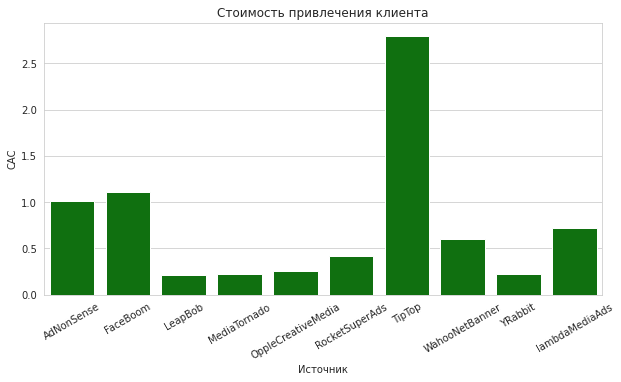

In [33]:
plt.figure(figsize=(10,5))
graf = sns.barplot(x='channel', y='cost_per_user', data=channel_cost, color='green')
graf.set_title('Стоимость привлечения клиента')
graf.set_xlabel('Источник')
graf.set_xticklabels(graf.get_xticklabels(),rotation = 30)
graf.set_ylabel('CAC')
plt.show()

Наибольшая стоимость привлечения одного клиента - через канал **TipTop**.

# Шаг 5. Оценка окупаемости рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируем общую окупаемость рекламы;
- Проанализируем окупаемость рекламы с разбивкой по устройствам;
- Проанализируем окупаемость рекламы с разбивкой по странам;
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

Ответим на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

При решении этого шага считается, что смотрим данные 1-го ноября 2019 года и что в организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Общая окупаемость рекламы

In [34]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [35]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [36]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [37]:
observation_date = datetime(2019, 11, 1).date()  # Задаем момент анализа
horizon_days = 14  # горизонт анализа 

In [38]:
profiles = get_profiles(visits, orders, costs) # Получаем профили пользователей
profiles = profiles.query('channel != "organic"') # Исключаем органических пользователей

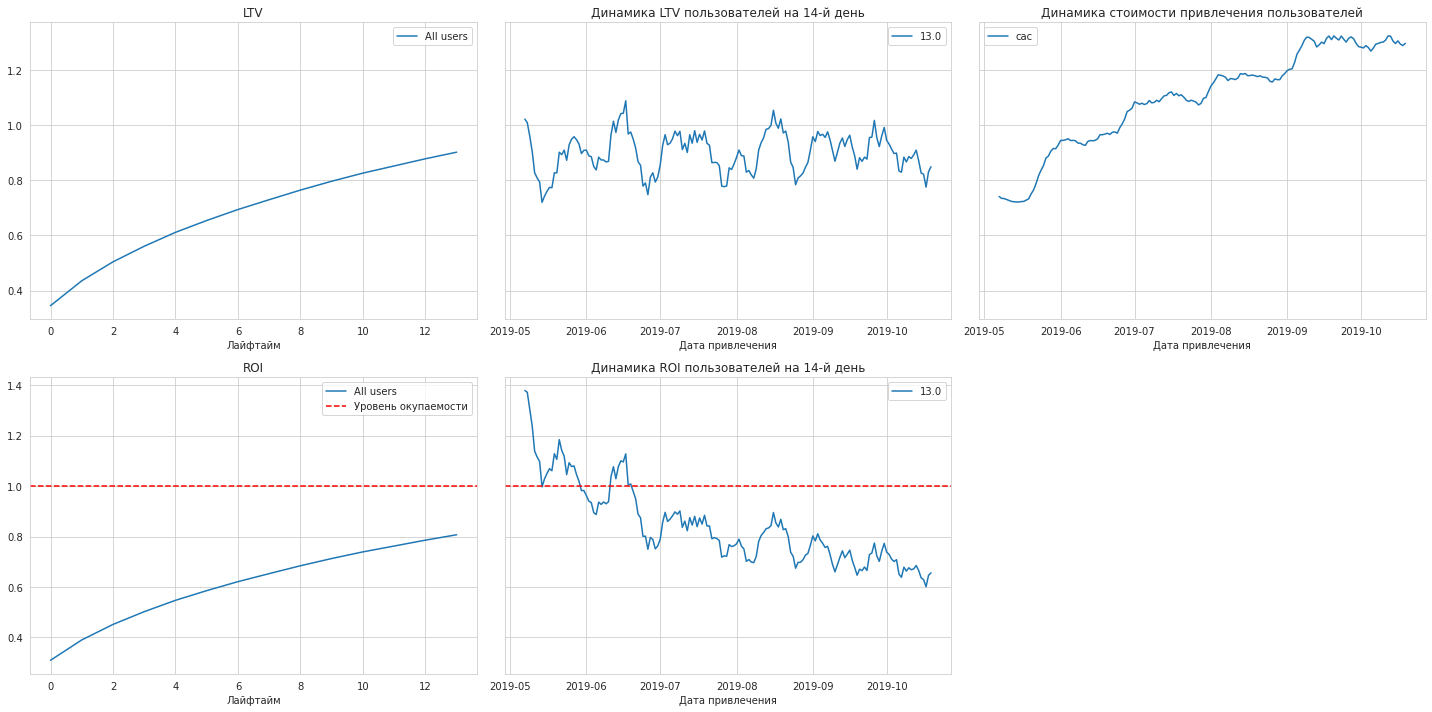

In [39]:
# Считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# Строим графики 
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам заметно следующее:

- Показатель LTV подвержен сезонности, но стабилен

- Реклама не окупается: показатель ROI не пересёк 100%

- CAC растет, затраты на рекламу постоянно повышались

### Окупаемость рекламы с разбивкой по устройствам

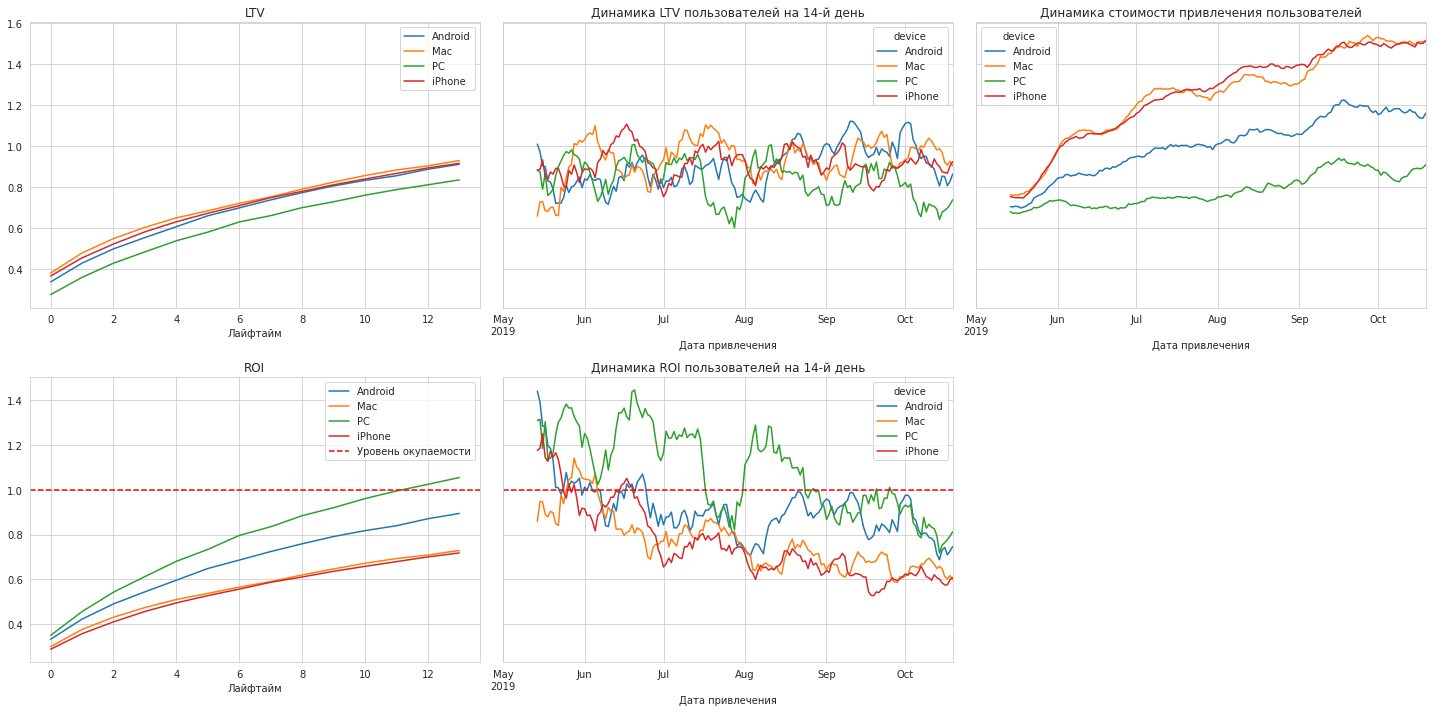

In [40]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

- Пользователи PC стабильно окупаются, а вот **пользователи iPhone и Mac и Android - нет**

Нужно узнать, в чем причина: в низкой конверсии или низком удержании:

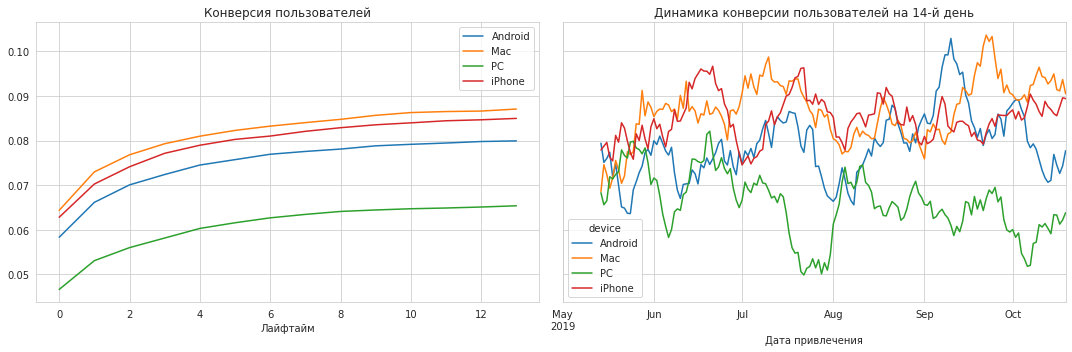

In [41]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

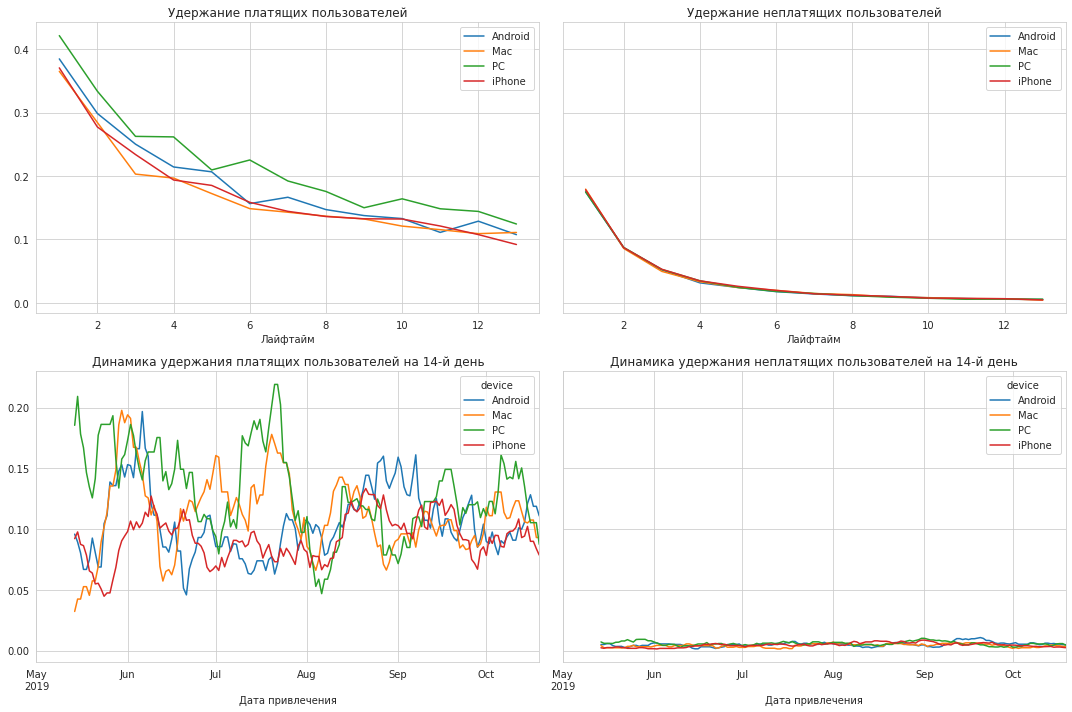

In [42]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание пользователей, использующих Android, iPhone или Mac, стабильны и находятся примерно на одинаковом уровне. Но этот показатель у них хуже, чем у пользователей компьютеров. Показатель конверсии у них выше, чем у PC. Необходимо проанализировать окупаемость рекламы в зависимости от других условий.

### Окупаемость рекламы с разбивкой по странам

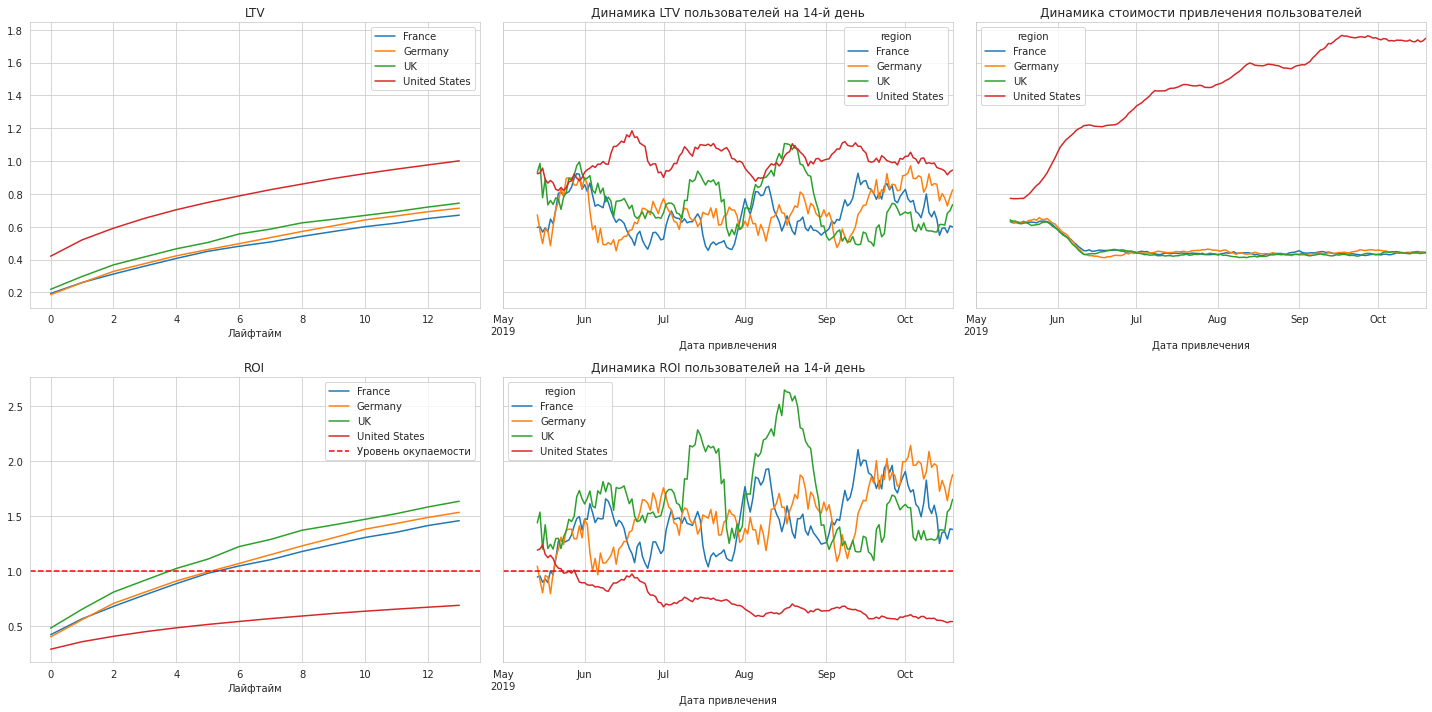

In [43]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

При разбивке по странам можно сказать, что:

- LTV все так же подвержен сезонности, но стабилен

- Стоимость привлечения пользователей из США заметно росла, в то время как стоимость привлечения пользователей из остальных стран оставалась примерно на одном уровне, намного ниже уровня США

- Реклама не окупается только в США


Отсюда можно сделать вывод, что, скорее всего, **имеется проблема с пользователями из США**

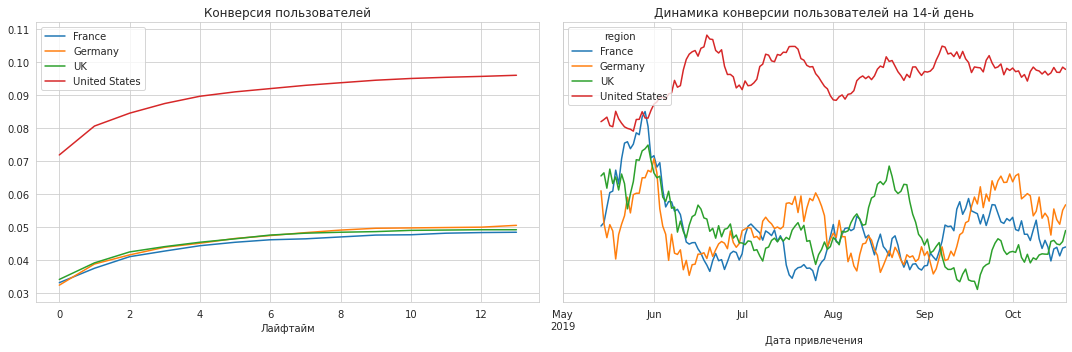

In [44]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

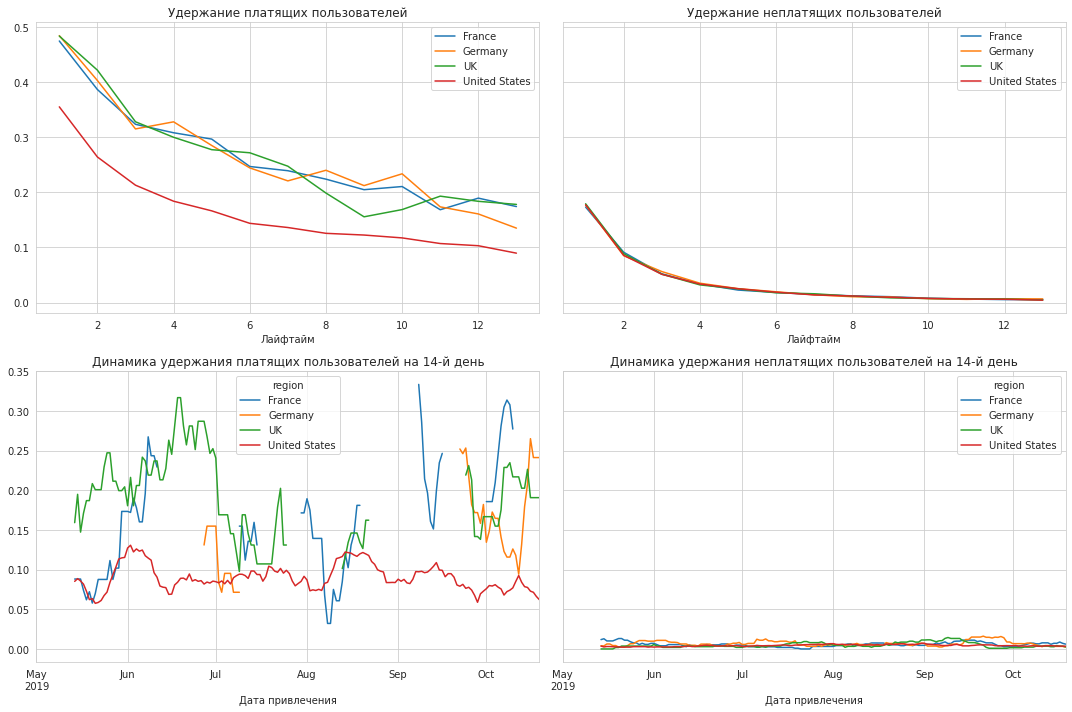

In [45]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Пользователи из США конвертируются очень хорошо, заметно лучше остальных, но их показатель удержания - **самый низкий**. Для платящих пользователей из США удержание 14-го дня на 10-15% ниже, чем у пользователей из Франции, Германии и Великобритании.

### Окупаемость рекламы с разбивкой по рекламным каналам

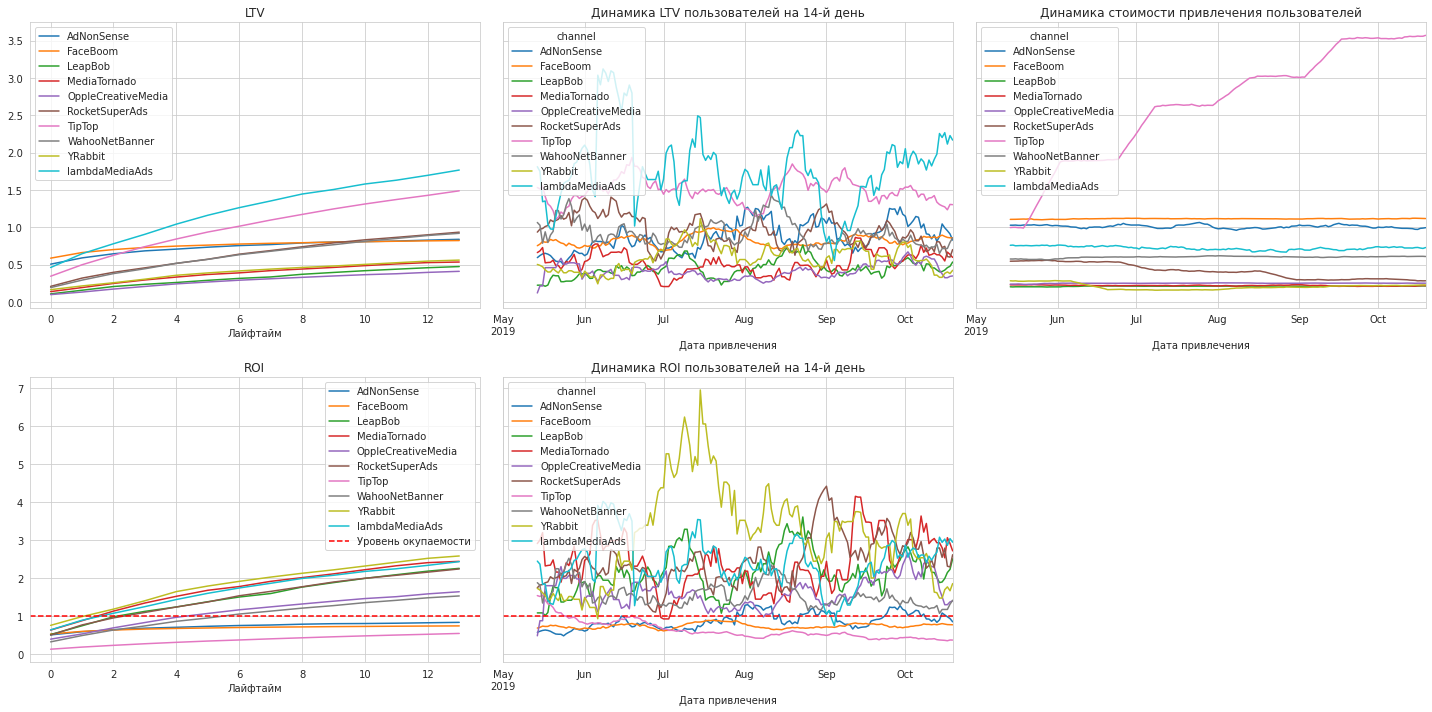

In [46]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

- Из множества каналов привлечения не окупаются только 3: TipTop, FaceBoom, AdNonSense. В будущем нужно детальнее рассмотреть, почему такие крупные каналы как FaceBoom и TipTop не приносят прибыли

- Стоимость привлечения пользователей через канал TipTop стремительно росла, туда вкладывалось заметно больше денег, чем в остальные каналы

- Показатель LTV пользователей, привлеченных через канал lambdaMediaAds, выглядит лучше остальных

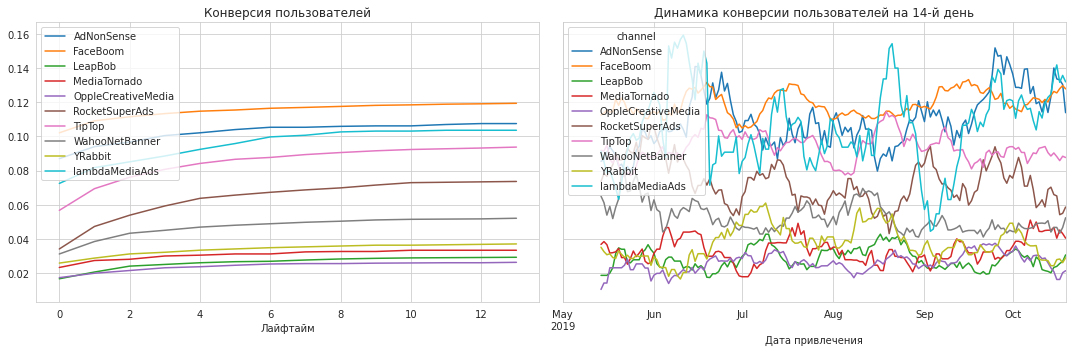

In [47]:
# смотрим конверсию с разбивкой по каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

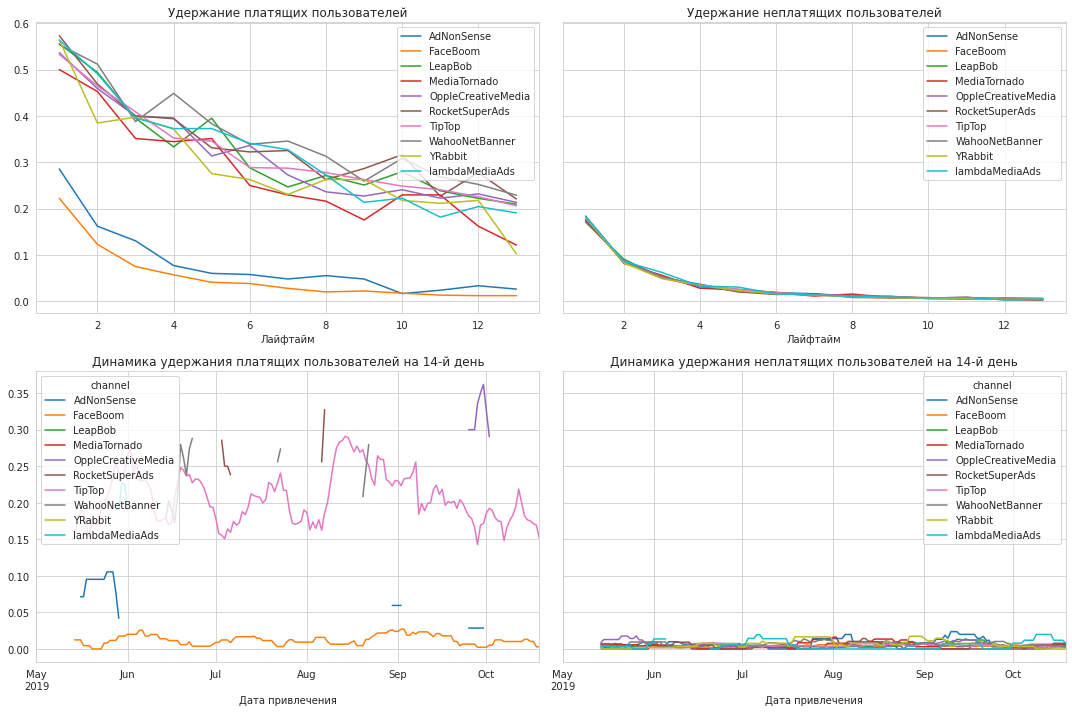

In [48]:
# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

У канала FaceBoom лучшая конверсия, но самый плохой показатель удержания. TipTop имеет конверсию чуть ниже, но удержание у него довольно большое.

# Шаг 6. Выводы

- В целом, реклама, направленная на привлечение пользователей, не окупается.

- Среди пользователей iPhone, Mac и Android не наблюдается окупаемости, хотя показатели конверсии и удержания у них не самые плохие. Нужно подробнее рассмотреть эти сегменты пользователей. Возможно, у части пользователей имеется проблема в использовании приложения на программном уровне.

- Заметны большие расходы на привелечение пользователей из США, которые очень даже хорошо конвертируются, но показатель их удержания заметно ниже пользователей из других стран. Необходимо детальнее разобраться в этом вопросе. Не хватает данных о севершенных операциях для проверки гипотез.

- Самыми плохо окупаемыми рекламными каналами оказались TipTop, FaceBoom и AdNonSense. FaceBoom и TipTop при этом привлекает достаточно большое количество пользователей, необходимо понять, что с ними может быть не так. Следует обратить внимание на каналы с наилучшими показателями ROI, конверсии и удержания, такие как lambdaMediaAds и RocketSuperAds.